In [8]:
import os
import rasterio as rio
import numpy as np
import shapely
import pyproj
import geopandas as gpd
import matplotlib.pyplot as plt
import rioxarray as riox
import rasterio as rio
import xarray as xr
import netCDF4
from osgeo import gdal
import pandas as pd
# import polars as pl
from datetime import datetime
import snowFun
import dask.array
# %matplotlib widget

# define folder and file paths
folder_AGVA = os.path.join('C:',os.sep,'Users','lzell','OneDrive - Colostate','Desktop',"AGVA")
folder_dems = os.path.join(folder_AGVA, "DEMs", "time_varying_DEMs", "10m")
folder_class = os.path.join(folder_AGVA, 'classified images', 'S2_Classified_Cloudmasked_Merged')
folder_cloud = os.path.join(folder_AGVA, 'classified images', 'S2_Cloud_Merged')
folder_meta = os.path.join(folder_AGVA, "classified images", "meta csv", "S2")
folder_dhdt = os.path.join(folder_AGVA, "dh_dt")

# open rgi
path_rgi = os.path.join(folder_AGVA, 'RGI', "01_rgi60_Alaska", "01_rgi60_Alaska.shp")
rgi_gdf = gpd.read_file(path_rgi, drop='geometry')


In [2]:
### choose if you want to do only the 45 validation glaciers
validation_only = 0

# open list of validation glaciers
all_validation_df = pd.read_csv(os.path.join(folder_AGVA, 'Validation', 'Validation Glaciers.csv'))

### get list of all the glaciers for which we have calculated the snow covered fractions
# select which rgis to analyze
if validation_only:
    folder_source = os.path.join(folder_AGVA, 'Derived products', 'S2', 'Validation', 'Annual AAs', 'csv')
    folder_save = os.path.join(folder_AGVA, 'Derived products', 'S2', 'Validation')
else:
    folder_source = os.path.join(folder_AGVA, 'Derived products', 'S2',  'Annual AAs', 'csv')
    folder_save = os.path.join(folder_AGVA, 'Derived products', 'S2')

# load rgi names that have been saved to the classified folder
rgis_to_analyze = list(set( [ i[3:17] for i in os.listdir(folder_source) if i!='merged.vrt' ] ))
rgis_to_analyze.sort()

print(len(rgis_to_analyze))

2984


In [29]:
# open dhdt, dropping unwanted columns
path_dhdt = os.path.join(folder_dhdt, "dh_01_rgi60_pergla_rates.csv")
dhdt_df = pd.read_csv(path_dhdt, usecols=["rgiid","period","dhdt"])

dhdt_df = dhdt_df[dhdt_df['period']=='2015-01-01_2020-01-01']
dhdt_df = dhdt_df[dhdt_df['rgiid'].isin(rgis_to_analyze)]
dhdt_df = dhdt_df.rename(columns={'rgiid':'RGIId'})
dhdt_df = dhdt_df.drop('period', axis=1)

print(dhdt_df.shape)
print(dhdt_df.head())


(2984, 2)
              RGIId    dhdt
160  RGI60-01.00004 -1.0619
202  RGI60-01.00005  0.3284
244  RGI60-01.00006  0.0705
412  RGI60-01.00010 -1.1346
496  RGI60-01.00012 -1.0326


### Create a single dataframe that hold the RGI info as well as the average ELA and AAR that we've found

In [30]:
# go through all the saved csvs, make a master csv with rgiid, median ela
all_files = [ i for i in os.listdir(os.path.join(folder_source)) if i[-3:]=='csv' ]

all_rgis = []
all_elas = []
all_aars = []

for f in all_files:
    
    # open
    df = pd.read_csv(os.path.join(folder_source, f))
    
    # get rgi
    all_rgis.append( f[3:17] )
    
    # get rid of the 'bad' years
    df = df[df['ela']>0]
    
    # get median ela, aar
    all_elas.append( np.nanmedian(df['ela']) )
    all_aars.append( np.nanmedian(df['aar']) )

# save everything
obs_df = pd.DataFrame({'RGIId':all_rgis, 'ela':all_elas, 'aar':all_aars}) 
# bulk_df.to_csv(os.path.join(folder_save, 'Region_04_2018_2022.csv'), index=False)

C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invali

C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invali

C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invali

C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invali

C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invali

C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\lzell\anaconda3\envs\AGVA_env\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invali

In [31]:
print(obs_df.dtypes)
obs_df.head()

RGIId     object
ela      float64
aar      float64
dtype: object


,RGIId,ela,aar
0,RGI60-01.00004,1880.0,0.365710
1,RGI60-01.00005,2030.0,0.340827
2,RGI60-01.00006,NaN,NaN
3,RGI60-01.00010,1990.0,0.168288
4,RGI60-01.00012,1890.0,0.206798


In [57]:
# add rgi info (area, zmin, zmax, etc...) to df
full_data_df = rgi_gdf[rgi_gdf['RGIId'].isin(rgis_to_analyze)]
full_data_df = full_data_df.merge(obs_df, on='RGIId')
full_data_df = full_data_df.merge(dhdt_df, on='RGIId')
full_data_df['dhdt'] = full_data_df['dhdt']*-1
full_data_df.head()

,RGIId,GLIMSId,BgnDate,EndDate,CenLon,CenLat,O1Region,O2Region,Area,Zmin,...,Connect,Form,TermType,Surging,Linkages,Name,geometry,ela,aar,dhdt
0,RGI60-01.00004,G213880E63381N,20090703,-9999999,-146.120,63.381,1,2,3.681,1273,...,0,0,0,9,9,NaN,"POLYGON ((-146.14895 63.37919, -146.14881 63.3...",1880.0,0.365710,1.0619
1,RGI60-01.00005,G212943E63551N,20090703,-9999999,-147.057,63.551,1,2,2.573,1494,...,0,0,0,9,9,NaN,"POLYGON ((-147.04307 63.55024, -147.04483 63.5...",2030.0,0.340827,-0.3284
2,RGI60-01.00006,G213756E63571N,20090703,-9999999,-146.244,63.571,1,2,10.470,1201,...,0,0,0,9,9,NaN,"POLYGON ((-146.24360 63.55621, -146.24376 63.5...",NaN,NaN,-0.0705
3,RGI60-01.00010,G212830E63513N,20090703,-9999999,-147.170,63.513,1,2,3.806,1280,...,0,0,0,9,9,NaN,"POLYGON ((-147.14936 63.50984, -147.14898 63.5...",1990.0,0.168288,1.1346
4,RGI60-01.00012,G213349E63366N,20090703,-9999999,-146.651,63.366,1,2,2.802,1318,...,0,0,0,9,9,NaN,"POLYGON ((-146.62609 63.37301, -146.62612 63.3...",1890.0,0.206798,1.0326


In [58]:
full_data_df.columns

Index(['RGIId', 'GLIMSId', 'BgnDate', 'EndDate', 'CenLon', 'CenLat',
       'O1Region', 'O2Region', 'Area', 'Zmin', 'Zmax', 'Zmed', 'Slope',
       'Aspect', 'Lmax', 'Status', 'Connect', 'Form', 'TermType', 'Surging',
       'Linkages', 'Name', 'geometry', 'ela', 'aar', 'dhdt'],
      dtype='object')

### Now let's make some plots to investigate some of these relationships

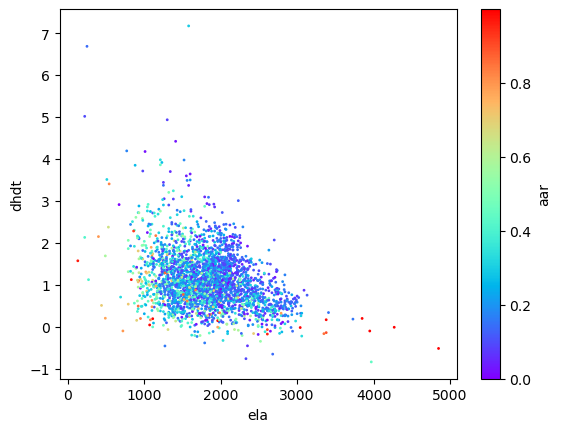

In [59]:
x_col = 'ela'
y_col = 'dhdt'
color_col = 'aar'
c_log = 0
cmap = 'rainbow'

X = full_data_df[x_col]
Y = full_data_df[y_col]
colors = full_data_df[color_col].astype(float)
if c_log: colors = np.log(colors)

fig, axs = plt.subplots()
sc = axs.scatter(X,Y, c=colors, s=1, cmap=cmap)
axs.set_xlabel(x_col)
axs.set_ylabel(y_col)
plt.colorbar(sc, label=color_col)

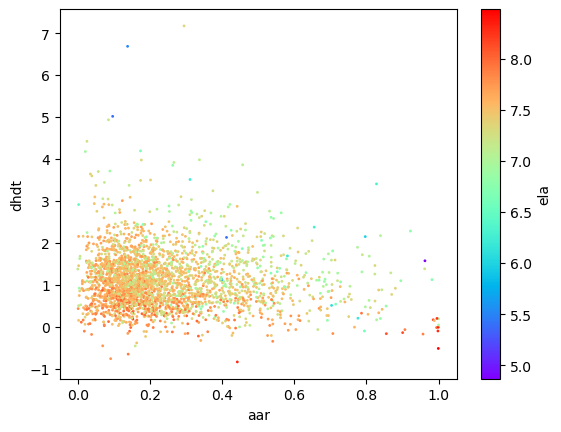

In [72]:
x_col = 'aar'
y_col = 'dhdt'
color_col = 'ela'
c_log = 1
cmap = 'rainbow'

X = full_data_df[x_col]
Y = full_data_df[y_col]
colors = full_data_df[color_col].astype(float)
if c_log: colors = np.log(colors)

fig, axs = plt.subplots()
sc = axs.scatter(X,Y, c=colors, s=1, cmap=cmap)
axs.set_xlabel(x_col)
axs.set_ylabel(y_col)
plt.colorbar(sc, label=color_col)

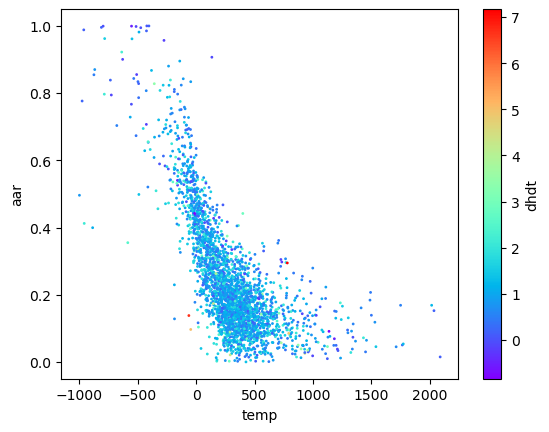

In [64]:
full_data_df['temp'] = full_data_df['ela'] - full_data_df['Zmed']  

x_col = 'temp'
y_col = 'aar'
color_col = 'dhdt'
c_log = 0
cmap = 'rainbow'

X = full_data_df[x_col]
Y = full_data_df[y_col]
colors = full_data_df[color_col].astype(float)
if c_log: colors = np.log(colors)

fig, axs = plt.subplots()
sc = axs.scatter(X,Y, c=colors, s=1, cmap=cmap)
axs.set_xlabel(x_col)
axs.set_ylabel(y_col)
plt.colorbar(sc, label=color_col)

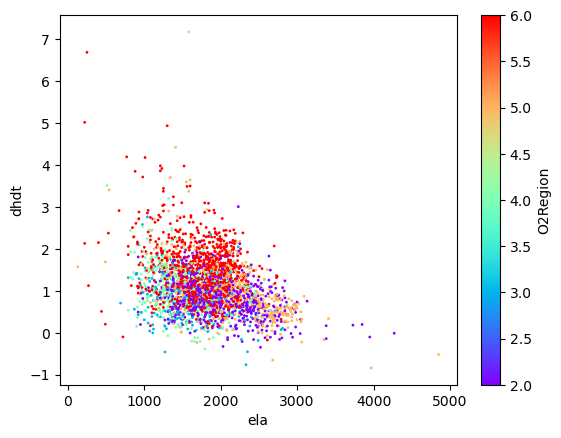

In [66]:
full_data_df['temp'] = full_data_df['ela'] - full_data_df['Zmed']  

x_col = 'ela'
y_col = 'dhdt'
color_col = 'O2Region'
c_log = 0
cmap = 'rainbow'

X = full_data_df[x_col]
Y = full_data_df[y_col]
colors = full_data_df[color_col].astype(float)
if c_log: colors = np.log(colors)

fig, axs = plt.subplots()
sc = axs.scatter(X,Y, c=colors, s=1, cmap=cmap)
axs.set_xlabel(x_col)
axs.set_ylabel(y_col)
plt.colorbar(sc, label=color_col)

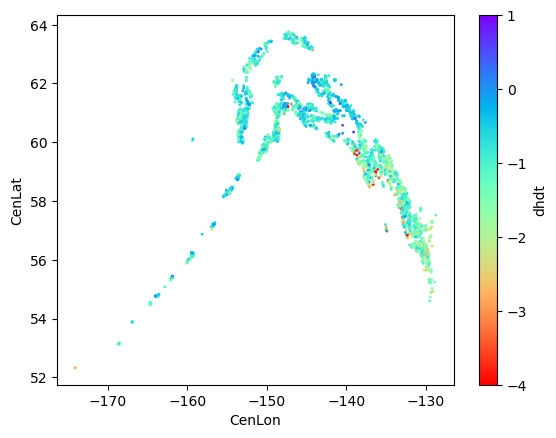

In [77]:
x_col = 'CenLon'
y_col = 'CenLat'
color_col = 'dhdt'
c_log = 0
cmap = 'rainbow_r'

X = full_data_df[x_col]
Y = full_data_df[y_col]
colors = full_data_df[color_col].astype(float)*-1
if c_log: colors = np.log(colors)

fig, axs = plt.subplots()
sc = axs.scatter(X,Y, c=colors, s=1, cmap=cmap, vmin=-4, vmax=1)
axs.set_xlabel(x_col)
axs.set_ylabel(y_col)
plt.colorbar(sc, label=color_col)